# Загрузка собственного набора изображений в TensorFlow и Keras

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Загружаем данные

In [ ]:
!unzip  /content/archive_4.zip -d fruit

Archive:  /content/archive_4.zip
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (1).jpg  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (1).png  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (1).webp  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (100).jpg  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (101).jpg  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (102).jpg  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (103).jpg  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple_fresh_001.jpg (104).jpg  
  inflating: fruit/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Fresh/apple

In [ ]:
import pathlib

In [ ]:
data_dir = pathlib.Path("/content/fruit/fruit")

In [ ]:
photo = list(data_dir.glob('StrawberryFresh/*'))

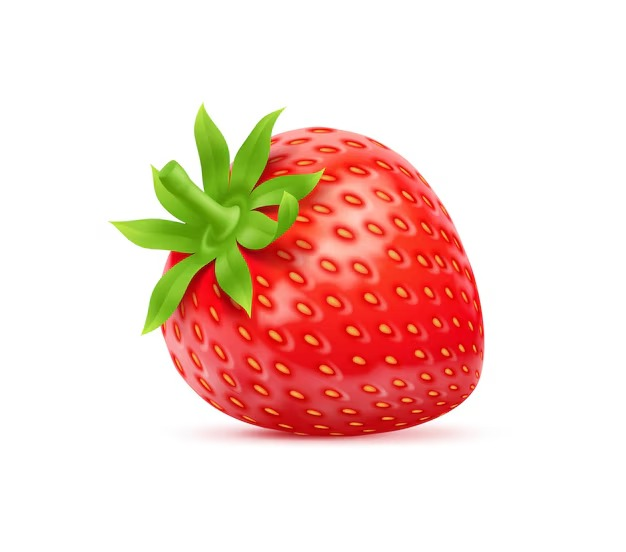

In [ ]:
PIL.Image.open(str(photo[0]))

## Создаем Tensorflow Dataset'ы

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

**Набор данных для обучения**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 529 files belonging to 6 classes.
Using 424 files for training.


**Проверочный набор данных**

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 529 files belonging to 6 classes.
Using 105 files for validation.


Названия классов в наборах данных.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['AppleFresh', 'AppleRotten', 'BananaFresh', 'BananaRotten', 'StrawberryFresh', 'StrawberryRotten']


**Примеры изображений**

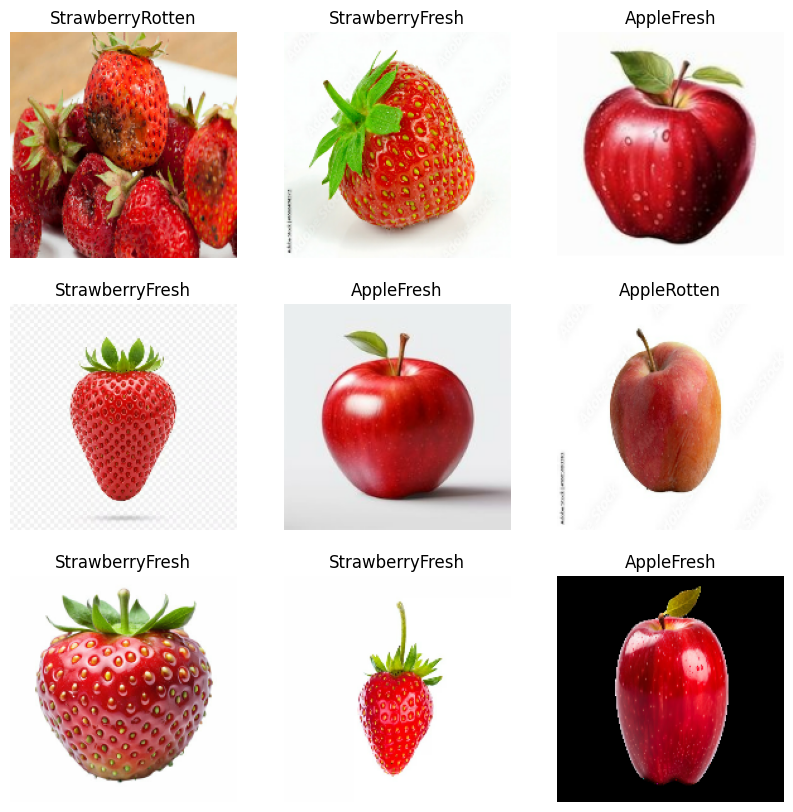

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Настраиваем производительность TensorFlow DataSet'ов

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [ ]:
model = keras.applications.MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Компилируем модель**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# Увеличение данных

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

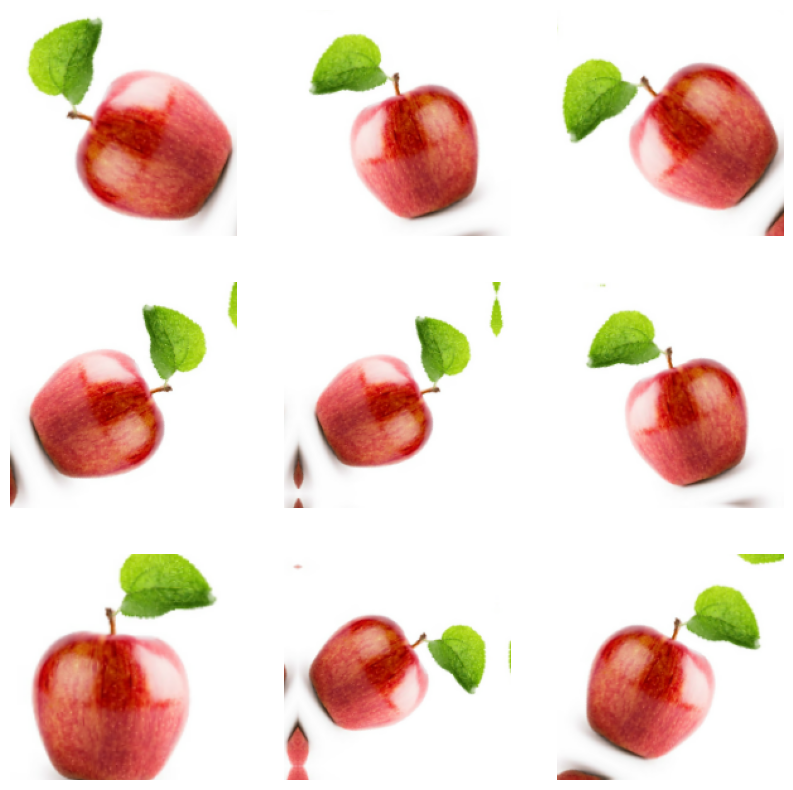

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Обучаем нейронную сеть

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2707 - loss: 2.4391 - val_accuracy: 0.4571 - val_loss: 1.3594
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5164 - loss: 1.3062 - val_accuracy: 0.6667 - val_loss: 0.9616
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7195 - loss: 0.9253 - val_accuracy: 0.7810 - val_loss: 0.7359
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7622 - loss: 0.7838 - val_accuracy: 0.7905 - val_loss: 0.6328
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7712 - loss: 0.6850 - val_accuracy: 0.8286 - val_loss: 0.5437
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7359 - loss: 0.7626 - val_accuracy: 0.7905 - val_loss: 0.6579
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7693 - loss: 0.6106 - val_accuracy: 0.8095 - val_loss: 0.5975
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8114 - loss: 0.5045 - val_accuracy: 0.7810 - v

## Оцениваем качетсво обучения сети

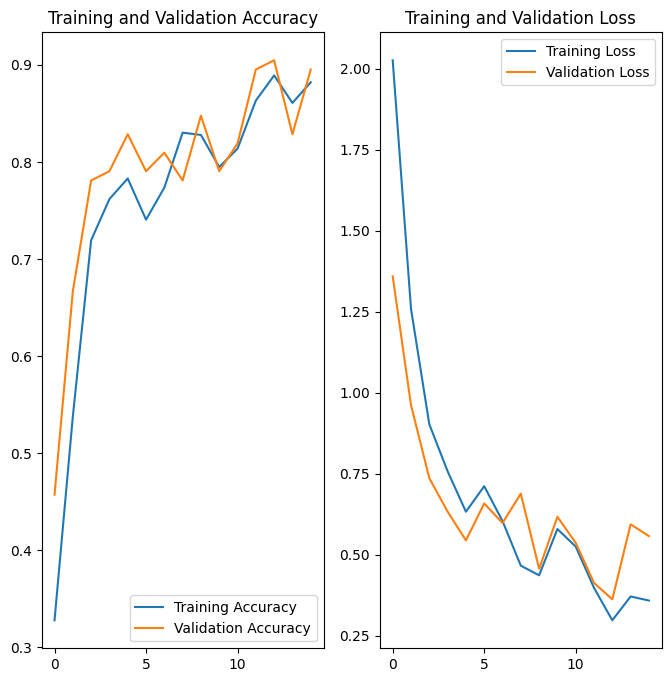

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("fruit.h5")

# Загружаем сохранённую модель

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

batch_size = 32
img_height = 180
img_width = 180

class_names = ['Яблоко', 'Гнилое яблоко', 'Банан', 'Гнилой банан', 'Клубнику', 'Гнилую клубнику']

model = keras.models.load_model('/content/fruit.h5')

# Проверяем работоспособность

In [ ]:
img = tf.keras.utils.load_img(
    "StrF.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

fruit = class_names[np.argmax(score)]
percent = round(100 * np.max(score), 2)

print(
    f"Это изображение похоже на {fruit} с вероятностью {percent}%."
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Это изображение похоже на Клубнику с вероятностью 97.51000213623047%.


In [ ]:
img = tf.keras.utils.load_img(
    "StrR.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

fruit = class_names[np.argmax(score)]
percent = round(100 * np.max(score), 2)

print(
    f"Это изображение похоже на {fruit} с вероятностью {percent}%."
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Это изображение похоже на Гнилую клубнику с вероятностью 72.0%.


In [ ]:
img = tf.keras.utils.load_img(
    "AppF.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

fruit = class_names[np.argmax(score)]
percent = round(100 * np.max(score), 2)

print(
    f"Это изображение похоже на {fruit} с вероятностью {percent}%."
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Это изображение похоже на Яблоко с вероятностью 99.95999908447266%.


In [ ]:
img = tf.keras.utils.load_img(
    "AppR.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

fruit = class_names[np.argmax(score)]
percent = round(100 * np.max(score), 2)

print(
    f"Это изображение похоже на {fruit} с вероятностью {percent}%."
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Это изображение похоже на Гнилое яблоко с вероятностью 62.0099983215332%.
